# Kaggle competition restaurant visitor forecasting competition
https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# format notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML, Javascript
display(HTML("<style>.container { width:90% !important; }</style>"))

# style pandas display
pd.set_option('display.max_columns', None)

# matplotlib magic
%matplotlib inline

In [2]:
def desc(df):
    display(df.head())
    print(df.shape)
    print(df.dtypes)

# Load data

In [3]:
air_reserve = pd.read_csv('../../data_files/air_reserve.csv')
air_store_info = pd.read_csv('../../data_files/air_store_info.csv', encoding='utf-8')
air_visit_data = pd.read_csv('../../data_files/air_visit_data.csv')
date_info = pd.read_csv('../../data_files/date_info.csv')
hpg_reserve = pd.read_csv('../../data_files/hpg_reserve.csv')
hpg_store_info = pd.read_csv('../../data_files/hpg_store_info.csv')
sample_submission = pd.read_csv('../../data_files/sample_submission.csv')
store_id_relation = pd.read_csv('../../data_files/store_id_relation.csv')

In [4]:
desc(air_reserve)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


(92378, 4)
air_store_id        object
visit_datetime      object
reserve_datetime    object
reserve_visitors     int64
dtype: object


In [5]:
desc(air_store_info)

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


(829, 5)
air_store_id       object
air_genre_name     object
air_area_name      object
latitude          float64
longitude         float64
dtype: object


In [6]:
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])

In [7]:
desc(air_visit_data)

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


(252108, 3)
air_store_id            object
visit_date      datetime64[ns]
visitors                 int64
dtype: object


In [8]:
desc(date_info)

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


(517, 3)
calendar_date    object
day_of_week      object
holiday_flg       int64
dtype: object


In [9]:
desc(hpg_reserve)

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


(2000320, 4)
hpg_store_id        object
visit_datetime      object
reserve_datetime    object
reserve_visitors     int64
dtype: object


In [10]:
desc(hpg_store_info)

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


(4690, 5)
hpg_store_id       object
hpg_genre_name     object
hpg_area_name      object
latitude          float64
longitude         float64
dtype: object


In [11]:
desc(sample_submission)

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


(32019, 2)
id          object
visitors     int64
dtype: object


In [12]:
desc(store_id_relation)

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


(150, 2)
air_store_id    object
hpg_store_id    object
dtype: object


## Holiday exploration

I found some more holidays, and made a new CSV that includes them.

In [13]:
expanded_date_info = pd.read_csv('../../data_files/expanded_date_info.csv')

In [14]:
desc(expanded_date_info)

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


(517, 3)
calendar_date    object
day_of_week      object
holiday_flg       int64
dtype: object


In [29]:
expanded_date_info.columns = ['calendar_date', 'day_of_week', 'exp_holiday_flg']
holiday_comparison = date_info.merge(expanded_date_info, how='left')

# compare holidays to extended holidays
holiday_comparison.loc[holiday_comparison['holiday_flg']!=holiday_comparison['exp_holiday_flg']]

,calendar_date,day_of_week,holiday_flg,exp_holiday_flg
44,2016-02-14,Sunday,0,1
62,2016-03-03,Thursday,0,1
188,2016-07-07,Thursday,0,1
359,2016-12-25,Sunday,0,1
410,2017-02-14,Tuesday,0,1
427,2017-03-03,Friday,0,1


In [31]:
expanded_date_info['calendar_date'] = pd.to_datetime(expanded_date_info['calendar_date'])

In [32]:
visitations_with_date_info = air_visit_data.merge(expanded_date_info, left_on='visit_date', right_on='calendar_date', how='left') 

In [33]:
visitations_with_date_info.head()

,air_store_id,visit_date,visitors,calendar_date,day_of_week,exp_holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,2016-01-13,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,2016-01-14,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,2016-01-15,Friday,0
3,air_ba937bf13d40fb24,2016-01-16,22,2016-01-16,Saturday,0
4,air_ba937bf13d40fb24,2016-01-18,6,2016-01-18,Monday,0


# Data viz

## Total and average (per party) number of visitors per day

In [13]:
agpd = air_visit_data.groupby('visit_date').agg(['sum', 'mean'])

In [14]:
agpd.columns = ['_'.join(tpl) for tpl in zip(agpd.columns.get_level_values(0), agpd.columns.get_level_values(1))]

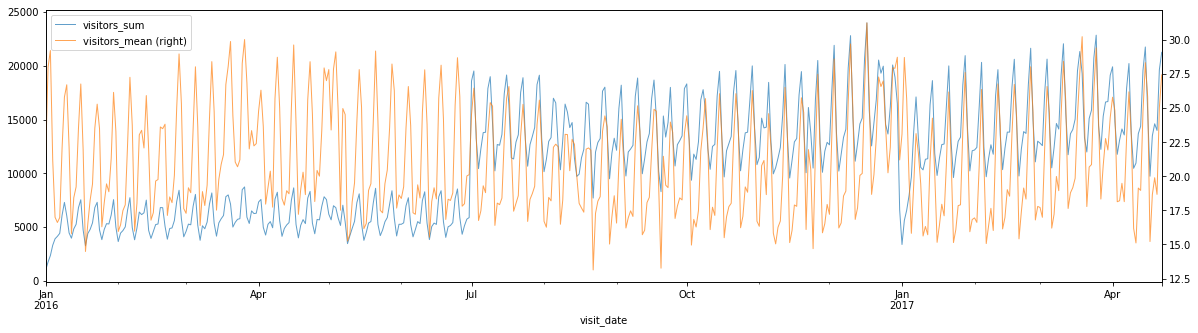

In [15]:
agpd.plot(
    kind='line',
    lw=1,
    figsize=(20, 5),
    secondary_y='visitors_mean',
    alpha=0.7
);

## Frequency of hour differences between reservation time and visit time

In [51]:
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime'])
air_reserve['reserve_datetime'] = pd.to_datetime(air_reserve['reserve_datetime'])

In [52]:
air_reserve['datediff_hours'] = (air_reserve['visit_datetime'] - air_reserve['reserve_datetime']).astype('timedelta64[h]')

In [53]:
air_reserve['datediff_days'] = (air_reserve['visit_datetime'] - air_reserve['reserve_datetime']).astype('timedelta64[D]')

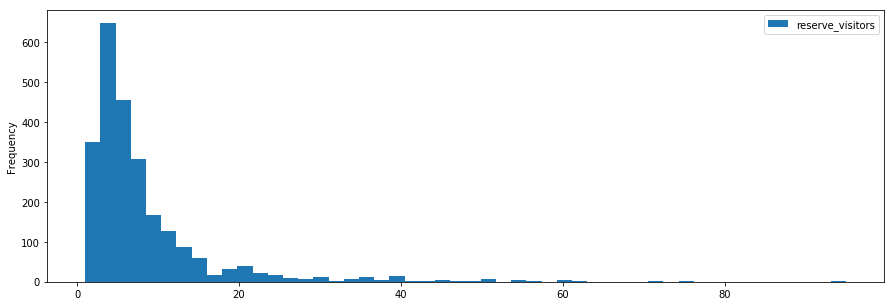

In [55]:
air_reserve[[
    'datediff_hours',
    'reserve_visitors'
]].groupby('datediff_hours').agg('mean').plot(
    kind='hist',
    figsize=(15, 5),
    bins=50
);

## Count of number of hours between reservation and visit times

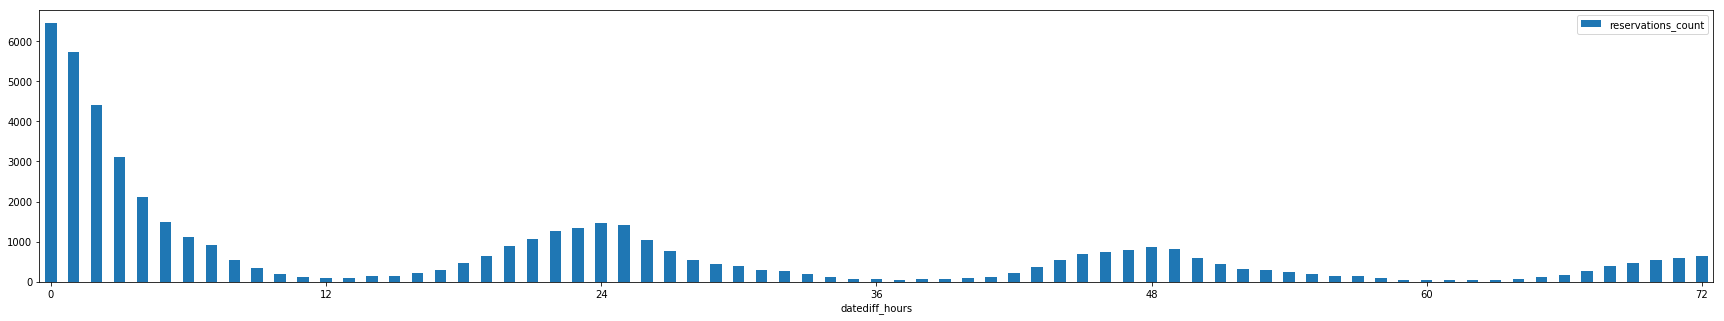

In [91]:
fig, ax = plt.subplots(figsize=(30, 5));

air_reserve[[
    'datediff_hours',
    'air_store_id'
]].groupby('datediff_hours', as_index=False).agg('count').astype(int).rename(columns={
    'air_store_id': 'reservations_count'
}).head(73).plot(
    kind='bar',
    figsize=(30, 5),
    x='datediff_hours',
    rot=0,
    xticks=[0, 12, 24, 36, 48, 60, 72],
#     yticks=[0, 1000, 2000],
    ax=ax
);

ax.set_xticks([0, 12, 24, 36, 48, 60, 72]);
ax.set_xticklabels([0, 12, 24, 36, 48, 60, 72]);

## Reserved visitors vs. time between reservation and visit

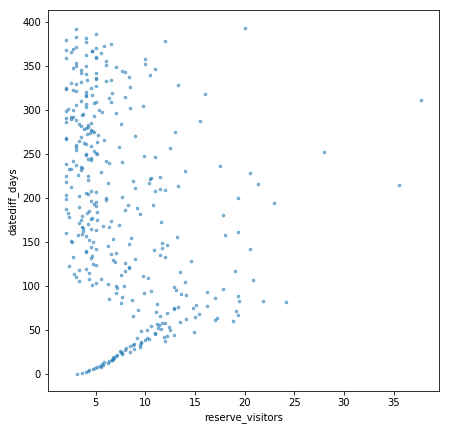

In [92]:
air_reserve.groupby('datediff_days', as_index=False).agg('mean').plot(
    kind='scatter',
    x='reserve_visitors',
    y='datediff_days',
    figsize=(7, 7),
    s=7,
    alpha=0.5
);

## Counts of genre & area name

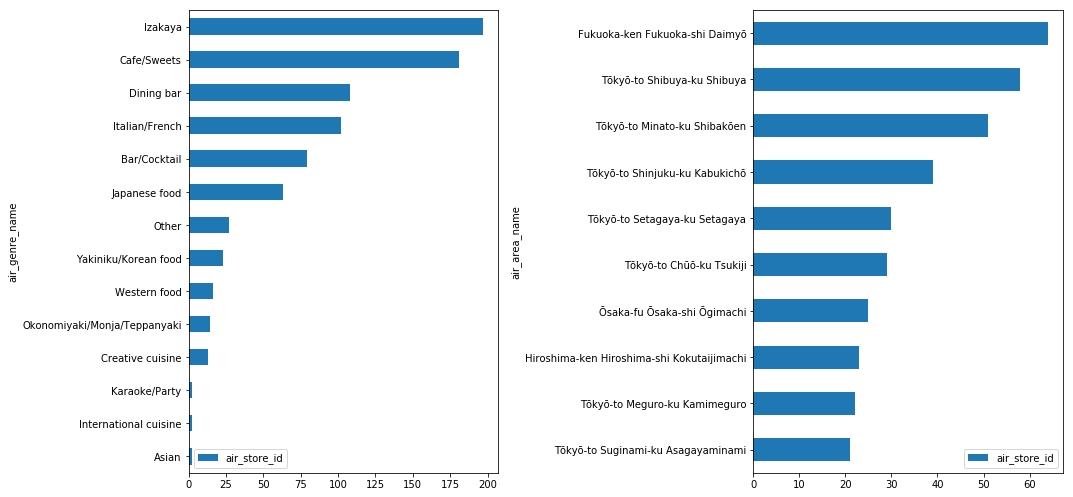

In [116]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7));

air_store_info[[
    'air_genre_name',
    'air_store_id'
]].groupby('air_genre_name').agg('count').sort_values('air_store_id', ascending=True).plot(
    kind='barh',
#     figsize=(10, 10),
    ax=axs[0]
);

air_store_info[[
    'air_area_name',
    'air_store_id'
]].groupby('air_area_name').agg('count').sort_values('air_store_id', ascending=True).tail(10).plot(
    kind='barh',
#     figsize=(20, 10),
    ax=axs[1]
);

plt.tight_layout();

### Heatmap of genre vs. area name

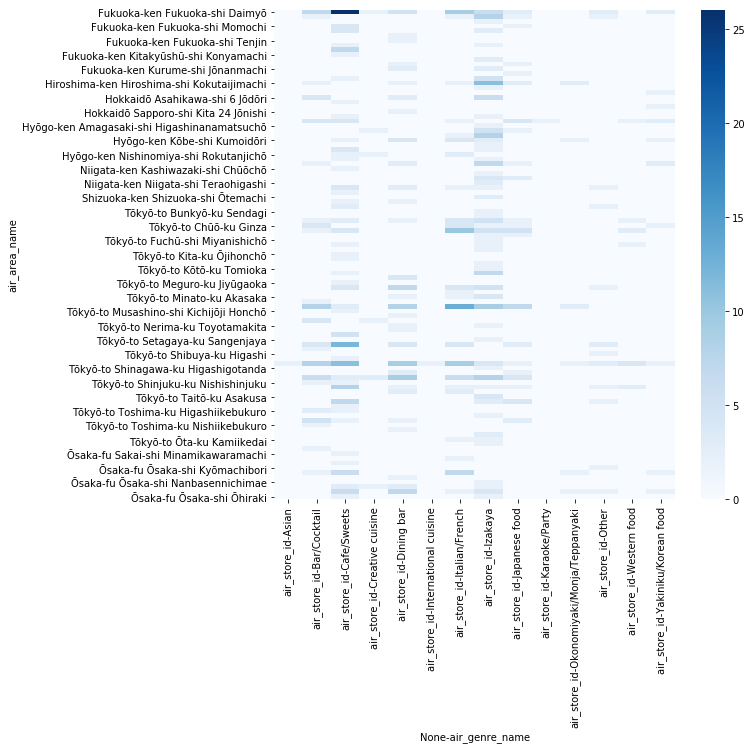

In [50]:
fig, ax = plt.subplots(figsize=(9, 9));

sns.heatmap(
        air_store_info[[
        'air_genre_name',
        'air_area_name',
        'air_store_id'
    ]].groupby(['air_area_name', 'air_genre_name']).agg('count').unstack().fillna(0),
    ax=ax,
    cmap='Blues'
);

## Scatter plot of latitude vs. longitude

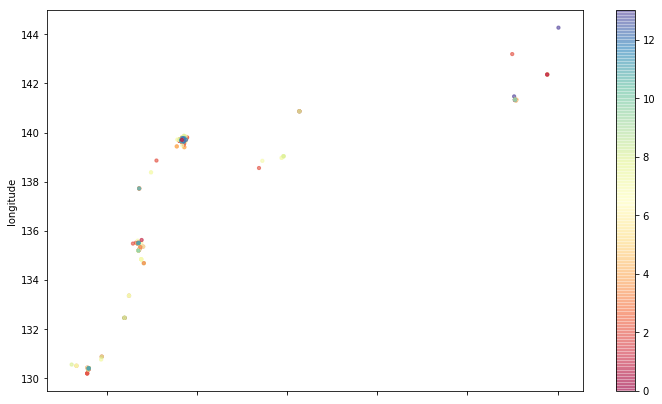

In [27]:
le = LabelEncoder()

air_store_info[[
    'latitude',
    'longitude'
]].plot(
    kind='scatter',
    x='latitude',
    y='longitude',
    figsize=(12, 7),
    s=10,
    alpha=0.4,
    c=le.fit_transform(air_store_info['air_genre_name']),
    cmap='Spectral'
);

## Difference between reservation time and visit time in days over time

In [28]:
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [29]:
air_reserve['reserve_date'] = pd.to_datetime(air_reserve['reserve_date'])

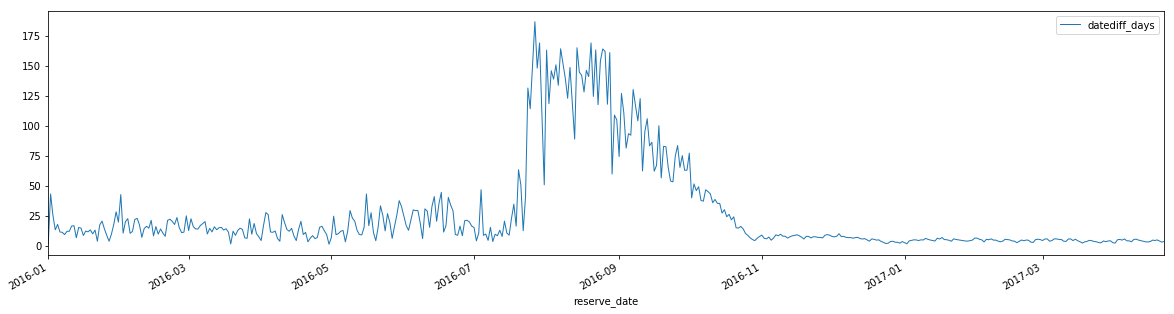

In [32]:
air_reserve[[
    'reserve_date',
    'datediff_days'
]].groupby('reserve_date', as_index=False).agg('mean').plot(
    kind='line',
    lw=1,
    figsize=(20, 5),
    x='reserve_date'
);

## Number of actual visitors and reserved visitors over time

In [33]:
air_reserve['visit_date'] = air_reserve['visit_datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [34]:
air_reserve['visit_date'] = pd.to_datetime(air_reserve['visit_date'])

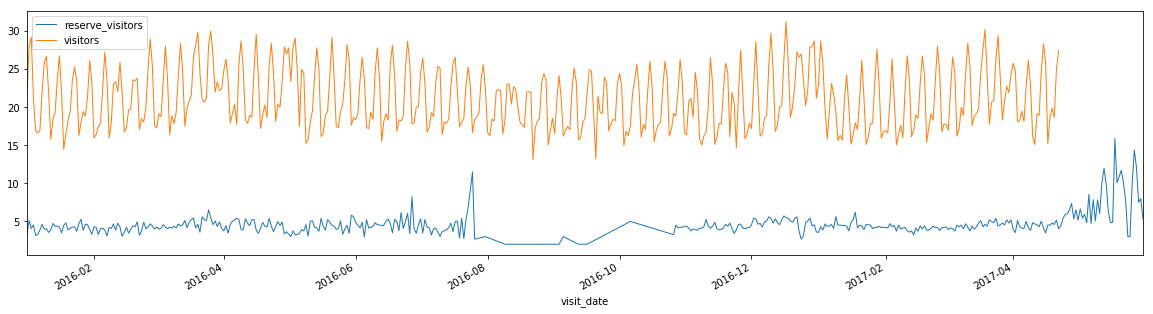

In [35]:
fig, ax = plt.subplots(figsize=(20, 5));

air_reserve[[
    'visit_date',
    'reserve_visitors'
]].groupby('visit_date', as_index=False).agg('mean').plot(
    kind='line',
    lw=1,
    ax=ax,
    x='visit_date'
);

air_visit_data[[
    'visit_date',
    'visitors'
]].groupby('visit_date', as_index=False).agg('mean').plot(
    kind='line',
    lw=1,
    ax=ax,
    x='visit_date'
);

## Counts by genre & area name

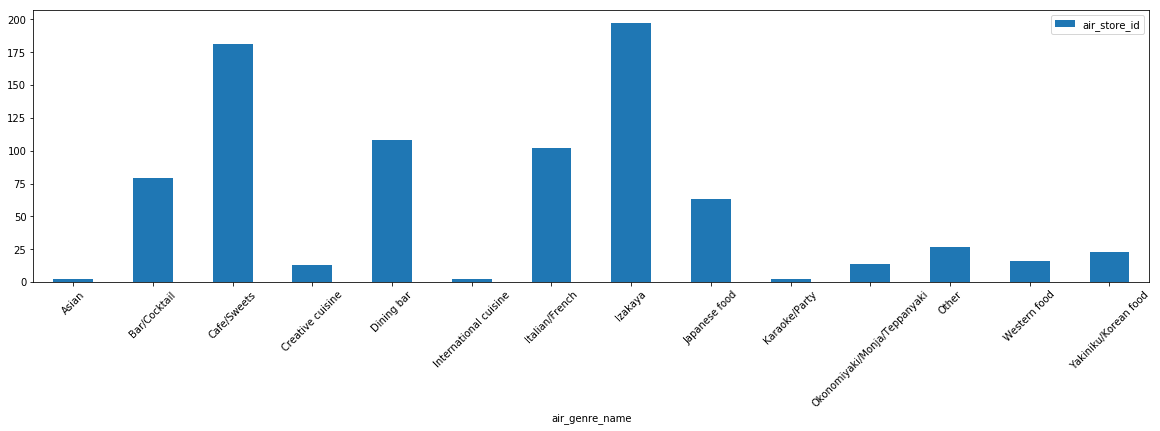

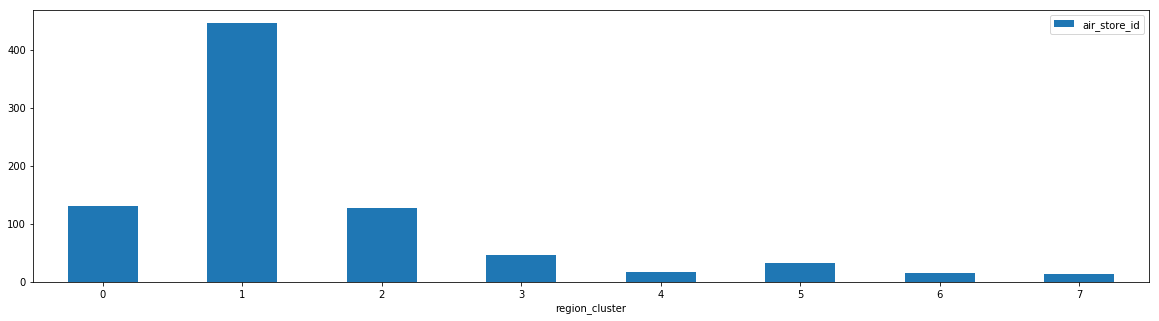

In [99]:
air_store_info[[
    'air_genre_name',
    'air_store_id'
]].groupby('air_genre_name').agg('count').plot(
    kind='bar',
    figsize=(20, 5),
    rot=45
);

air_store_info[[
    'region_cluster',
    'air_store_id'
]].groupby('region_cluster').agg('count').plot(
    kind='bar',
    figsize=(20, 5),
    rot=0
);

## Counting unique locations with visitors per day

In [97]:
air_visit_data.shape
air_visit_data[[
    'air_store_id',
    'visit_date'
]].drop_duplicates().shape

(252108, 3)

(252108, 2)

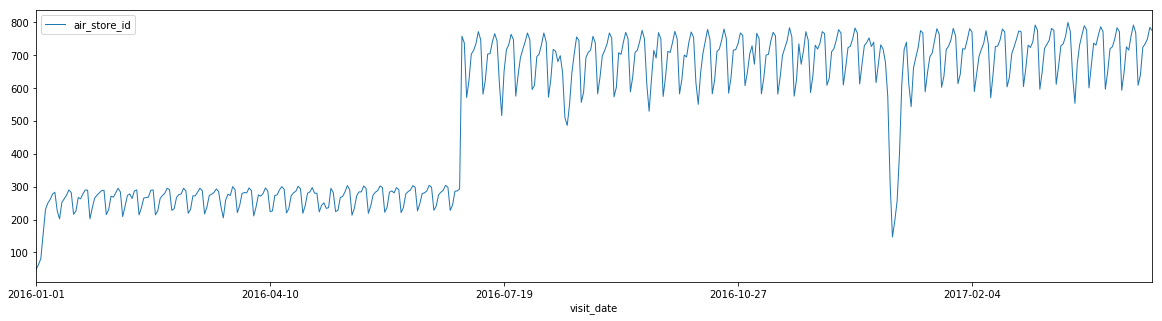

In [98]:
air_visit_data[[
    'air_store_id',
    'visit_date'
]].groupby('visit_date', as_index=False).agg('count').plot(
    kind='line',
    lw=1,
    figsize=(20, 5),
    x='visit_date'
);

# Feature engineering

## Cluster latitude longitude

In [6]:
X = air_store_info[[
    'latitude',
    'longitude'
]].values

sil_scores = []

for k in range(2, 20):
    kmeans = KMeans(
        n_clusters=k,
        random_state=42
    );

    kmeans.fit(X);
    
    sil_score = silhouette_score(X, kmeans.predict(X))
    
    sil_scores.append((k, sil_score))   

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=11, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=13, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=17, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=18, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=19, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

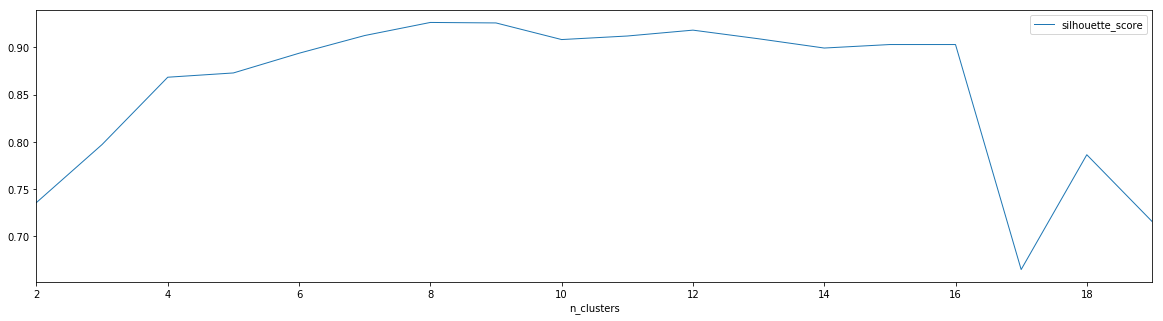

In [7]:
pd.DataFrame(sil_scores).rename(columns={0: 'n_clusters', 1: 'silhouette_score'}).plot(
    kind='line',
    lw=1,
    figsize=(20, 5),
    x='n_clusters'
);

In [10]:
pd.DataFrame(sil_scores).rename(columns={0: 'n_clusters', 1: 'silhouette_score'}).sort_values('silhouette_score', ascending=False).head()

,n_clusters,silhouette_score
6,8,0.926483
7,9,0.925967
10,12,0.918342
5,7,0.912631
9,11,0.912121


Choose `n_clusters == 8`

In [11]:
kmeans = KMeans(
    n_clusters=8,
    random_state=42
)

X = air_store_info[[
    'latitude',
    'longitude'
]].values

kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

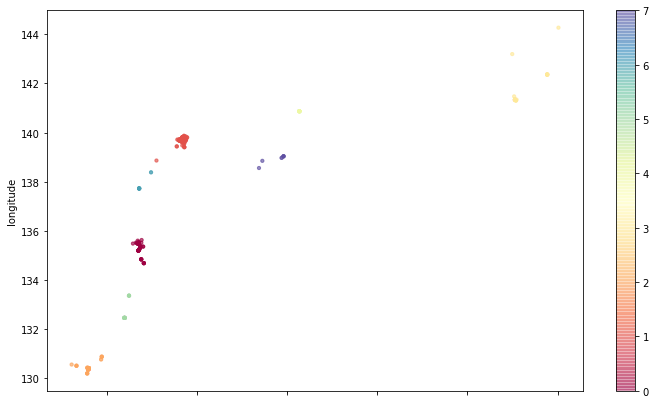

In [12]:
air_store_info[[
    'latitude',
    'longitude'
]].plot(
    kind='scatter',
    x='latitude',
    y='longitude',
    figsize=(12, 7),
    s=10,
    alpha=0.4,
    c=kmeans.predict(X),
    cmap='Spectral'
);

### Add cluster labels to store info dataframe

In [13]:
air_store_info['region_cluster'] = kmeans.predict(X)

### Heatmap of location cluster vs. genre

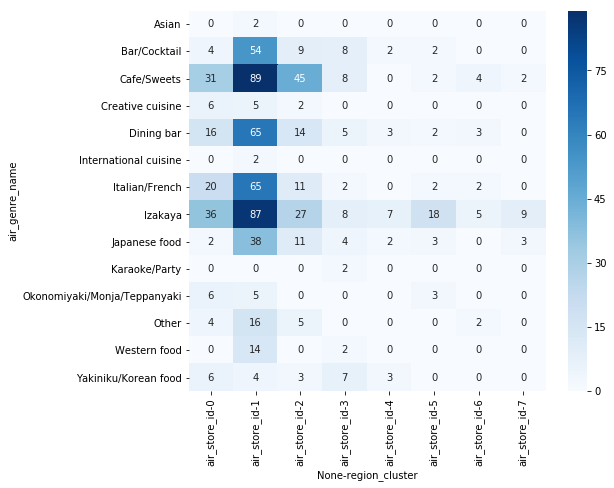

In [28]:
fig, ax = plt.subplots(figsize=(8, 7));

sns.heatmap(
    air_store_info[[
        'air_genre_name',
        'region_cluster',
        'air_store_id'
    ]].groupby(['air_genre_name', 'region_cluster']).agg('count').unstack().fillna(0),
    ax=ax,
    cmap='Blues',
    annot=True
);

### Heatmap of location cluster vs. area name

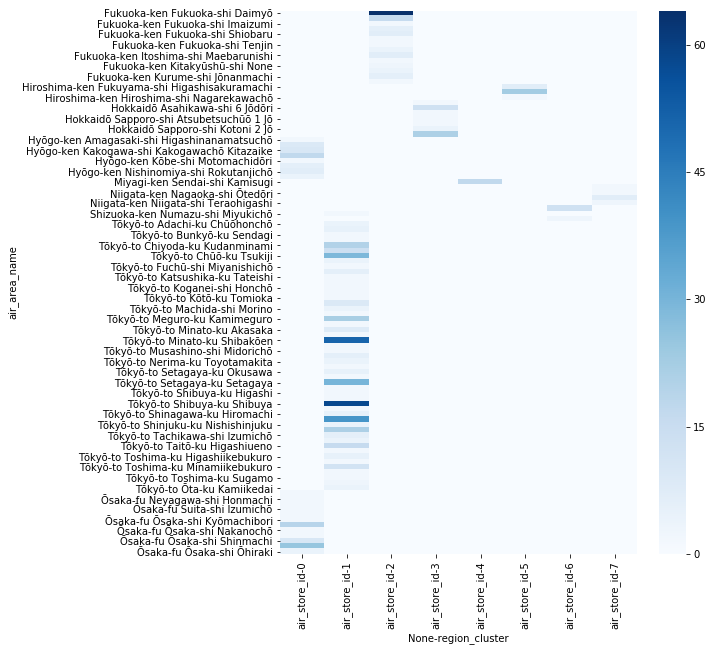

In [43]:
fig, ax = plt.subplots(figsize=(8, 10));

sns.heatmap(
    air_store_info[[
        'air_area_name',
        'region_cluster',
        'air_store_id'
    ]].groupby(['air_area_name', 'region_cluster']).agg('count').unstack().fillna(0),
    ax=ax,
    cmap='Blues',
    annot=False
);

### Cluster map of location cluster vs. area name

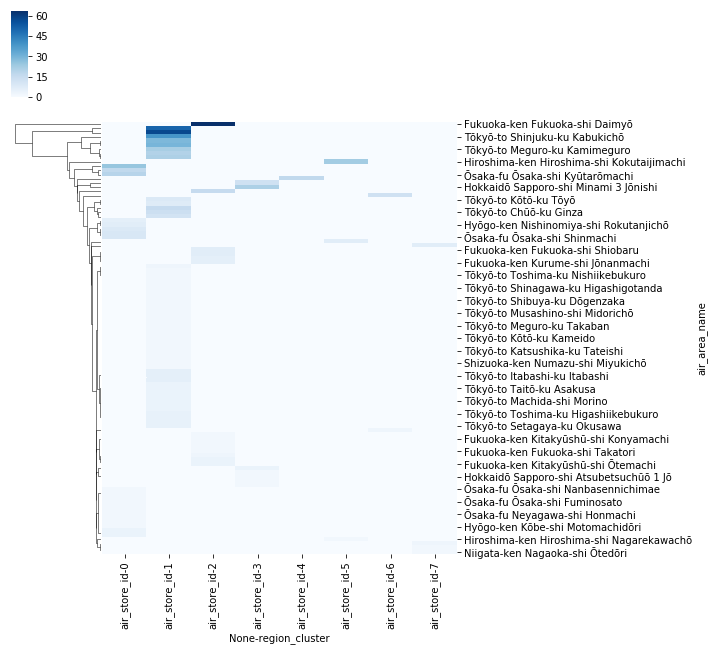

In [36]:
sns.clustermap(
    data=air_store_info[[
        'air_area_name',
        'region_cluster',
        'air_store_id'
    ]].groupby(['air_area_name', 'region_cluster']).agg('count').unstack().fillna(0),
    figsize=(8, 10),
    cmap='Blues',
    col_cluster=False
);